In [ ]:
library(tidyverse)
options(repr.plot.width=10, repr.plot.height=6)

# STATS 504
## Week 7: Matching and applied causal inference

In [2]:
# libraries needed to follow along with today's lecture
 install.packages(c('cobalt', 'Lahman', 'MatchIt', 'WeightIt'))

also installing the dependencies ‘chk’, ‘RcppProgress’, ‘sandwich’





The downloaded binary packages are in
	/var/folders/ng/qcb7p5f14nl6kwpxnh6rz73h0000gn/T//RtmplCwhZe/downloaded_packages


### The Sympson's Paradox

- `UCBAdmissions` (built into base R) is a $6 \times 2 \times 2$ contingency table on admissions to graduate programs at UC Berkeley. 
- (The department names have been anonymized to ABCDEF for privacy.)

In [8]:
UCBAdmissions %>% as_tibble %>% head

Admit,Gender,Dept,n
<chr>,<chr>,<chr>,<dbl>
Admitted,Male,A,512
Rejected,Male,A,313
Admitted,Female,A,89
Rejected,Female,A,19
Admitted,Male,B,353
Rejected,Male,B,207


## 🤔 Bias?

What was the `male:female` odds ratio of getting admitted to graduate school at UC Berkeley?
<ol style="list-style-type: upper-alpha;">
    <li>Greater that 2:1</li>
    <li>Greater that 1:1 but less that 2:1</li>
    <li>Less that 1:1 but more than 1:2</li>
    <li>Less that 1:2</li>
</ol>

In [6]:
# code

UCBAdmissions %>% margin.table(-3) %>% fisher.test


	Fisher's Exact Test for Count Data

data:  .
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.621356 2.091246
sample estimates:
odds ratio 
  1.840856 


In [12]:
help(UCBAdmissions)

## 🤔 Confounding?

Of the six departments, how many of them admitted a greater percentage of women than men?

<ol style="list-style-type: upper-alpha;">
    <li>1</li>
    <li>2</li>
    <li>4</li>
    <li>All six</li>
</ol>

In [15]:
UCBAdmissions %>% prop.table(c(2,3))

, , Dept = A

          Gender
Admit            Male     Female
  Admitted 0.62060606 0.82407407
  Rejected 0.37939394 0.17592593

, , Dept = B

          Gender
Admit            Male     Female
  Admitted 0.63035714 0.68000000
  Rejected 0.36964286 0.32000000

, , Dept = C

          Gender
Admit            Male     Female
  Admitted 0.36923077 0.34064081
  Rejected 0.63076923 0.65935919

, , Dept = D

          Gender
Admit            Male     Female
  Admitted 0.33093525 0.34933333
  Rejected 0.66906475 0.65066667

, , Dept = E

          Gender
Admit            Male     Female
  Admitted 0.27748691 0.23918575
  Rejected 0.72251309 0.76081425

, , Dept = F

          Gender
Admit            Male     Female
  Admitted 0.05898123 0.07038123
  Rejected 0.94101877 0.92961877


What if we run the same test of proportions within each department?

In [7]:
# code

apply(UCBAdmissions, 3, fisher.test, simplify=T)

$A

	Fisher's Exact Test for Count Data

data:  array(newX[, i], d.call, dn.call)
p-value = 1.669e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1970420 0.5920417
sample estimates:
odds ratio 
 0.3495628 


$B

	Fisher's Exact Test for Count Data

data:  array(newX[, i], d.call, dn.call)
p-value = 0.6771
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2944986 2.0040231
sample estimates:
odds ratio 
 0.8028124 


$C

	Fisher's Exact Test for Count Data

data:  array(newX[, i], d.call, dn.call)
p-value = 0.3866
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8452173 1.5162918
sample estimates:
odds ratio 
    1.1329 


$D

	Fisher's Exact Test for Count Data

data:  array(newX[, i], d.call, dn.call)
p-value = 0.5995
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6789572 1.2504742
sample estimates:
odds ra

### Example from baseball: the 1981 MLB season

- The 1981 MLB season was unique due to a players' strike that occurred from June 12 to August 8, resulting in approximately two months of inactivity.
- To address the disruption, MLB decided to split the season into two halves, with the winners of each half in each division competing in the Divisional Championship Series.
    - **First Half**: The season before the strike determined the first half's winners.
    - **Second Half**: After play resumed on August 9, the records were reset, and the second half began, determining the second half's winners.
    - **Postseason Qualification**: Winners of each half in the four divisions (East and West in both the American and National Leagues) would face off in the first round of the postseason.

In [9]:
# install.packages("Lahman")
library(Lahman)

### The Controversy

- The split-season format could (and did) lead to teams with superior overall records being excluded from the postseason because they did not win either half.
- A team could have the best overall winning percentage in its division and still miss the playoffs if it finished second in both halves.
    - The Cincinnati Reds had the best overall record in the Major Leagues in 1981 but did not qualify for the postseason.
    - St. Louis Cardinals had the best overall record in the NL East but failed to make the postseason.


In [10]:
TeamsHalf %>% filter(lgID == "NL", divID == "W") %>% mutate(
    wpct = W / (W + L)
)

yearID,lgID,teamID,Half,divID,DivWin,Rank,G,W,L,wpct
<int>,<fct>,<fct>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>
1981,NL,ATL,1,W,N,4,54,25,29,0.4629630
1981,NL,ATL,2,W,N,5,52,25,27,0.4807692
1981,NL,CIN,1,W,N,2,56,35,21,0.6250000
1981,NL,CIN,2,W,N,2,52,31,21,0.5961538
1981,NL,HOU,1,W,N,3,57,28,29,0.4912281
1981,NL,HOU,2,W,N,1,53,33,20,0.6226415
1981,NL,LAN,1,W,N,1,57,36,21,0.6315789
1981,NL,LAN,2,W,N,4,53,27,26,0.5094340
1981,NL,SDN,1,W,N,6,56,23,33,0.4107143


Why did Cincinnati and St. Louis fail to make the playoffs?

In [ ]:
# code

In [12]:
library(MatchIt)
data(lalonde)

## LaLonde data 
- Study examining the impact of a job training program (National Supported Work Demonstration) on the post-training earnings.
- Goal: evaluate the causal effect of job training programs on participants' earnings.
- (Famous example of a causal inference dataset.)

In [13]:
help(lalonde)

- `treat`: Indicator variable for treatment group (1 for treated, 0 for control).
- `age`: Age of the individuals.
- `educ`: Years of education.
- `black`, `hispan`: Race/ethnicity indicators.
- `married`: Marital status indicator.
- `nodegree`: Indicator for individuals without a high school degree.
- `re74`, `re75`: Real earnings in 1974 and 1975, before the training.
- `re78`: Real earnings in 1978, after the training.

## The naive estimator
- First let's naively estimate the treatment effect without using any causal inference methods.

In [14]:
# Naive regression: re78 ~ treat
model_naive <- lm(re78 ~ treat, data = lalonde)

# Show regression summary
summary(model_naive)


Call:
lm(formula = re78 ~ treat, data = lalonde)

Residuals:
   Min     1Q Median     3Q    Max 
 -6984  -6349  -2048   4100  53959 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6984.2      360.7  19.362   <2e-16 ***
treat         -635.0      657.1  -0.966    0.334    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7471 on 612 degrees of freedom
Multiple R-squared:  0.001524,	Adjusted R-squared:  -0.0001079 
F-statistic: 0.9338 on 1 and 612 DF,  p-value: 0.3342


## Propensity scoring
Now let's use propensity scoring to reweight the data.

In [15]:
prop_mdl <- glm(treat ~ age + educ + race + re74 + re75, data = lalonde, family = "binomial")

summary(prop_mdl)

p <- prop_mdl$fitted.values



Call:
glm(formula = treat ~ age + educ + race + re74 + re75, family = "binomial", 
    data = lalonde)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.703e-02  6.265e-01  -0.043  0.96558    
age         -4.023e-04  1.280e-02  -0.031  0.97492    
educ         7.744e-02  4.629e-02   1.673  0.09439 .  
racehispan  -2.161e+00  3.617e-01  -5.974 2.32e-09 ***
racewhite   -3.205e+00  2.836e-01 -11.303  < 2e-16 ***
re74        -8.312e-05  2.845e-05  -2.922  0.00348 ** 
re75         3.021e-05  4.426e-05   0.682  0.49493    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 751.49  on 613  degrees of freedom
Residual deviance: 500.78  on 607  degrees of freedom
AIC: 514.78

Number of Fisher Scoring iterations: 5


In [16]:
lalonde %>% 
    mutate(ate.weights = 1 / (treat * p + (1 - treat) * (1 - p))) ->
    lalonde_wts

Warning message:
“Standardized mean differences and raw mean differences are present in
the same plot. Use the `stars` argument to distinguish between them and
appropriately label the x-axis. See `?love.plot` for details.”


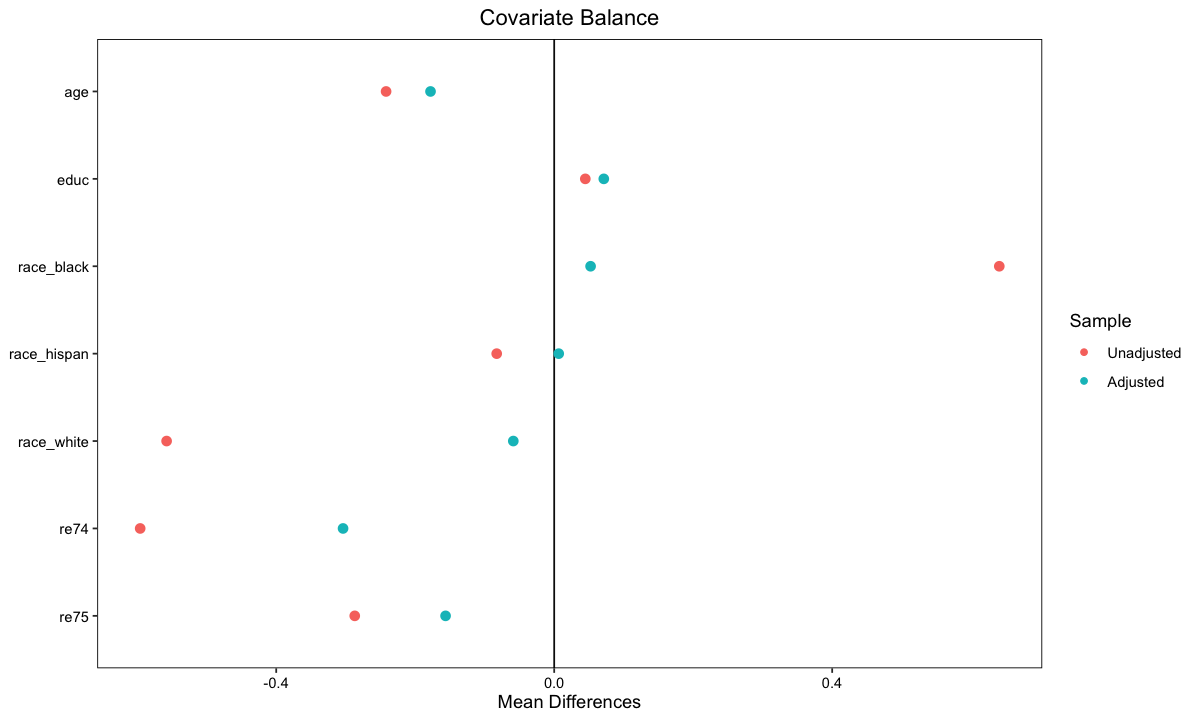

In [24]:
library(cobalt)

bal.tab(treat ~ age + educ + race + re74 + re75, 
        data = lalonde_wts,
        weights = "ate.weights",
        estimand = "ATE", un = T) %>% plot

In [25]:
prop_mdl2 <- glm(treat ~ poly(age, 2) + race + educ + re74 + re75, 
                 data = lalonde, family = "binomial")

p2 <- prop_mdl2$fitted.values

lalonde_wts %>% mutate(ate.weights2 = 1 / (treat * p2 + (1 - treat) * (1 - p2))) ->
    lalonde_wts

In [26]:
library(cobalt)
bal.tab(treat ~ age + educ + race + re74 + re75, 
        data = lalonde_wts,
        weights = c("ate.weights", "ate.weights2"),
        estimand = "ATE", un = T)

Balance Measures
               Type Diff.Un Diff.ate.weights Diff.ate.weights2
age         Contin. -0.2419          -0.1780           -0.3187
educ        Contin.  0.0448           0.0714            0.0800
race_black   Binary  0.6404           0.0524            0.0602
race_hispan  Binary -0.0827           0.0065            0.0397
race_white   Binary -0.5577          -0.0589           -0.0999
re74        Contin. -0.5958          -0.3038           -0.2241
re75        Contin. -0.2870          -0.1563           -0.0557

Effective sample sizes
             Control Treated
All           429.    185.  
ate.weights   336.05   74.74
ate.weights2  295.51   64.9 

## The ATT vs. ATE
- Last lecture we looked at the average treatment effect (ATE):

$$\text{ATE} = \mathbb{E}_{x\sim p(x)}[Y_1(x) - Y_0(x)]$$

- Another common measure is the average treatement effect on the treated (ATT):

$$\text{ATT} = \mathbb{E}_{x\sim p(x \mid T=1)}[Y_1(x) - Y_0(x)]$$

- When should we use one versus the other?

### Propensity weights for ATT
- For the $T=1$ group, no reweighting.
- For the $T=0$ group,

$$
\mathbb{E}_{x \sim p(x \mid T=1)} Y_0(x)  =
\mathbb{E}_{x \sim p(x \mid T=0)} \frac{p(x \mid T=1)}{p(x \mid T=0)} Y_0(x) 
$$

Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the `stars` argument to distinguish between them and appropriately label the x-axis.”


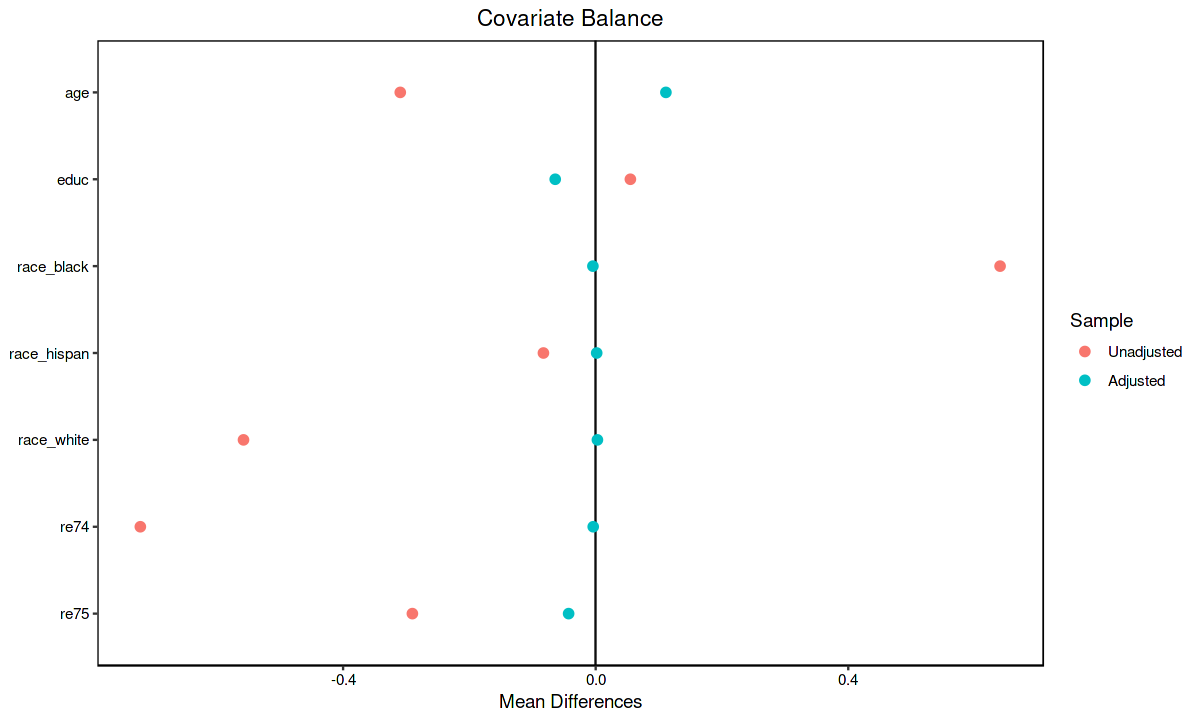

In [17]:
lalonde_wts <- lalonde_wts %>% mutate(att.weights = treat + (1 - treat) * p / (1 - p))

bal.tab(treat ~ age + educ + race + re74 + re75, 
        data = lalonde_wts, 
        weights = "att.weights",
        estimand = "ATT", un = T) %>% plot

## Automating this process
- Now that you've learned what the weights represent (i.e. by computing them by hand), you have my blessing to use a package :-)

In [20]:
library(WeightIt)

#Generating propensity score weights for the ATT
W.out <- WeightIt::weightit(treat ~ age + educ + race + re74 + re75,
                            data = lalonde,
                            method = "glm",
                            estimand = "ATT")

bal.tab(W.out, un = T)

W.out

Balance Measures
                Type Diff.Un Diff.Adj
prop.score  Distance  1.7919  -0.0397
age          Contin. -0.3094   0.1112
educ         Contin.  0.0550  -0.0641
race_black    Binary  0.6404  -0.0044
race_hispan   Binary -0.0827   0.0016
race_white    Binary -0.5577   0.0028
re74         Contin. -0.7211  -0.0039
re75         Contin. -0.2903  -0.0428

Effective sample sizes
           Control Treated
Unadjusted   429.      185
Adjusted     108.2     185

A weightit object
 - method: "glm" (propensity score weighting with GLM)
 - number of obs.: 614
 - sampling weights: none
 - treatment: 2-category
 - estimand: ATT (focal: 1)
 - covariates: age, educ, race, re74, re75

Warning message:
“Standardized mean differences and raw mean differences are present in
the same plot. Use the `stars` argument to distinguish between them and
appropriately label the x-axis. See `?love.plot` for details.”


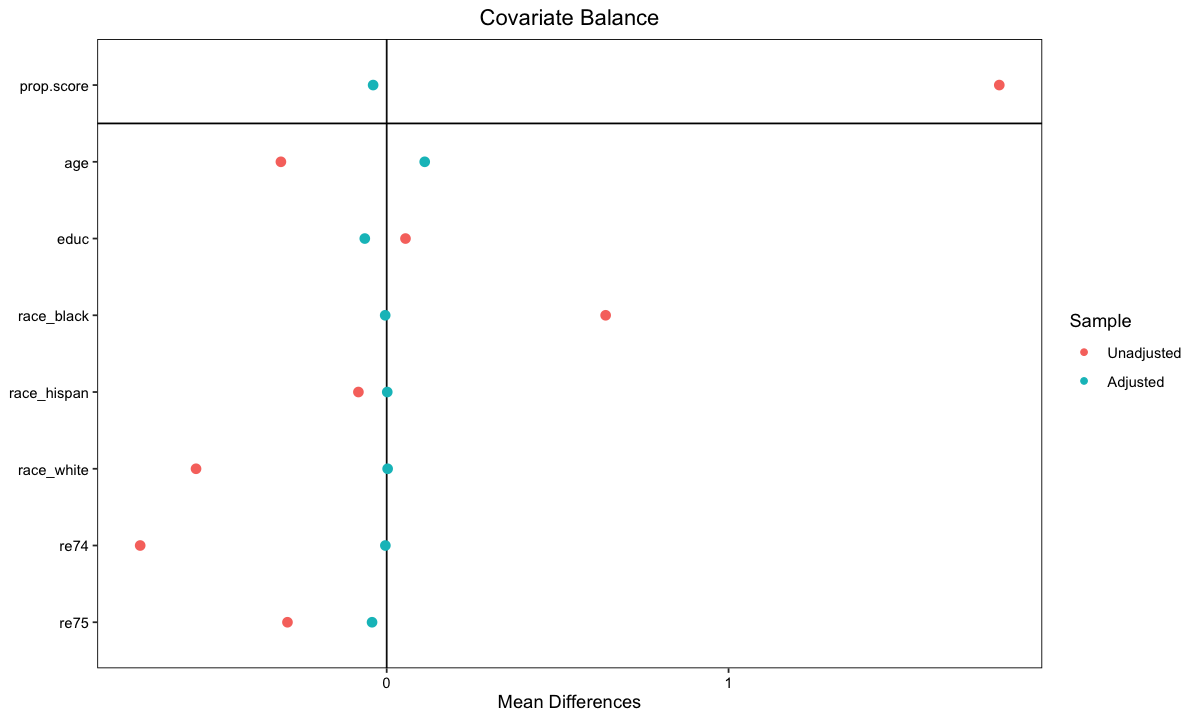

In [21]:
plot(bal.tab(W.out, un = T))

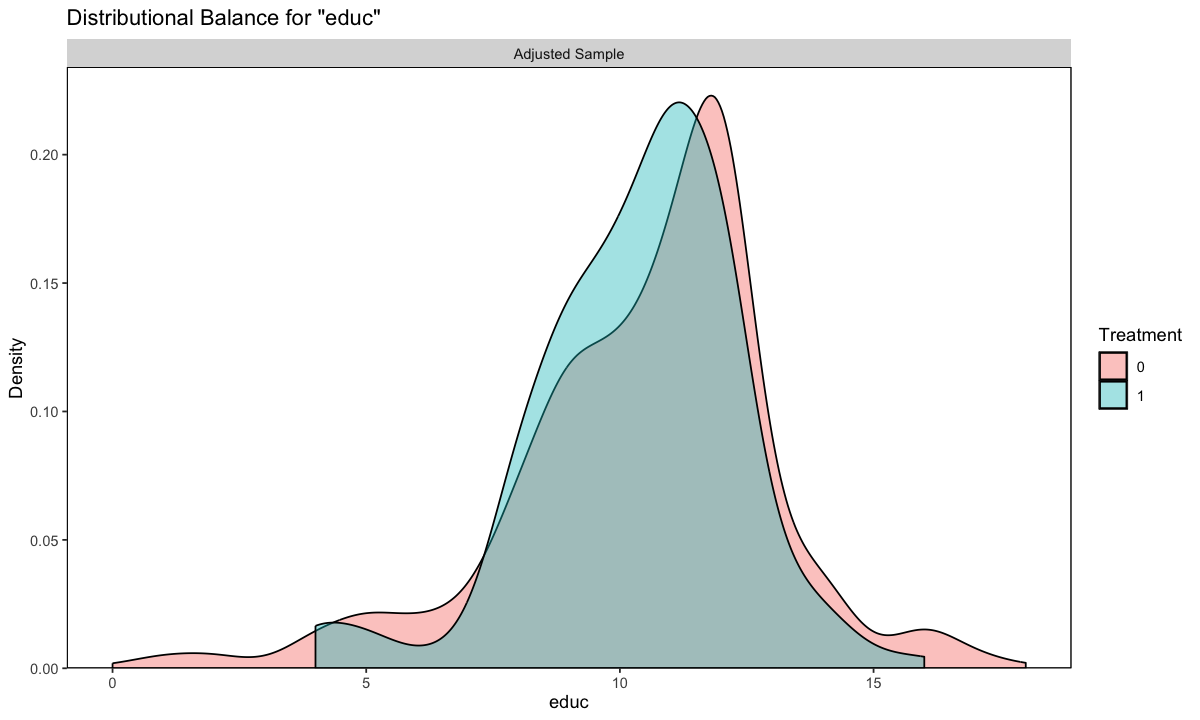

In [22]:
# bal.plot(W.out, var.name = "age")
bal.plot(W.out, var.name = "educ")

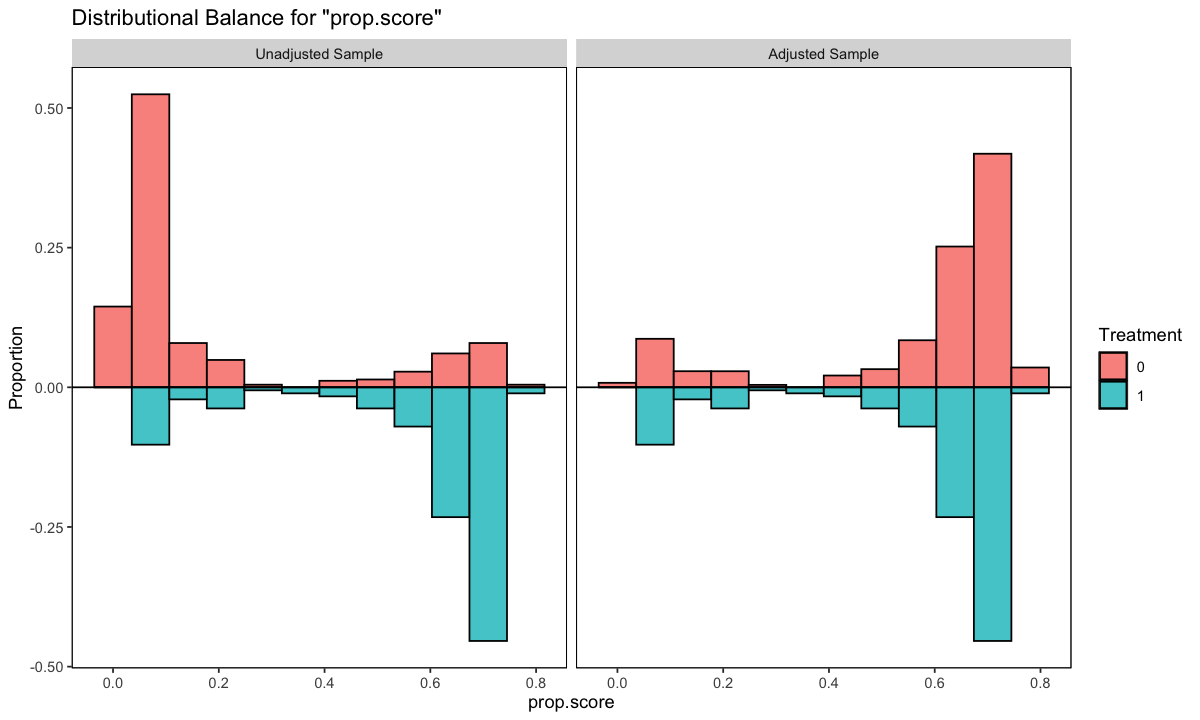

In [23]:
#Before and after weighting; which = "both"
bal.plot(W.out, var.name = "prop.score",
         which = "both",
         type = "histogram",
         mirror = TRUE)

Finally we can estimate the ATT effect using the weights:

In [32]:
lm(re78 ~ age + educ + race + re74 + re75 + treat, data = lalonde_wts, weights = att.weights) %>% 
    summary


Call:
lm(formula = re78 ~ age + educ + race + re74 + re75 + treat, 
    data = lalonde_wts, weights = att.weights)

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-12155  -2262   -532   1824  53893 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.066e+03  1.646e+03  -0.648  0.51737    
age          6.975e+00  3.255e+01   0.214  0.83042    
educ         5.048e+02  1.234e+02   4.089 4.91e-05 ***
racehispan   1.444e+03  1.199e+03   1.204  0.22915    
racewhite    1.233e+03  9.538e+02   1.292  0.19675    
re74        -5.580e-03  7.844e-02  -0.071  0.94331    
re75         3.443e-01  1.120e-01   3.073  0.00221 ** 
treat        1.291e+03  5.582e+02   2.313  0.02105 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5386 on 606 degrees of freedom
Multiple R-squared:  0.06559,	Adjusted R-squared:  0.0548 
F-statistic: 6.077 on 7 and 606 DF,  p-value: 7.15e-07


## Weaknesses of propensity score reweighting
- We have to get the propensity score model correct.
- If the model is misspecified, it will bias our estimates.
- What happens when $\mathbb{P}(T = 1 \mid x)$ is near zero or one?

## Matching
- Matching is an alternative method of doing causal inference using observational data.
- Instead of building a "parametric" propensity score model, we simply match each sample with its counterfactual twin.
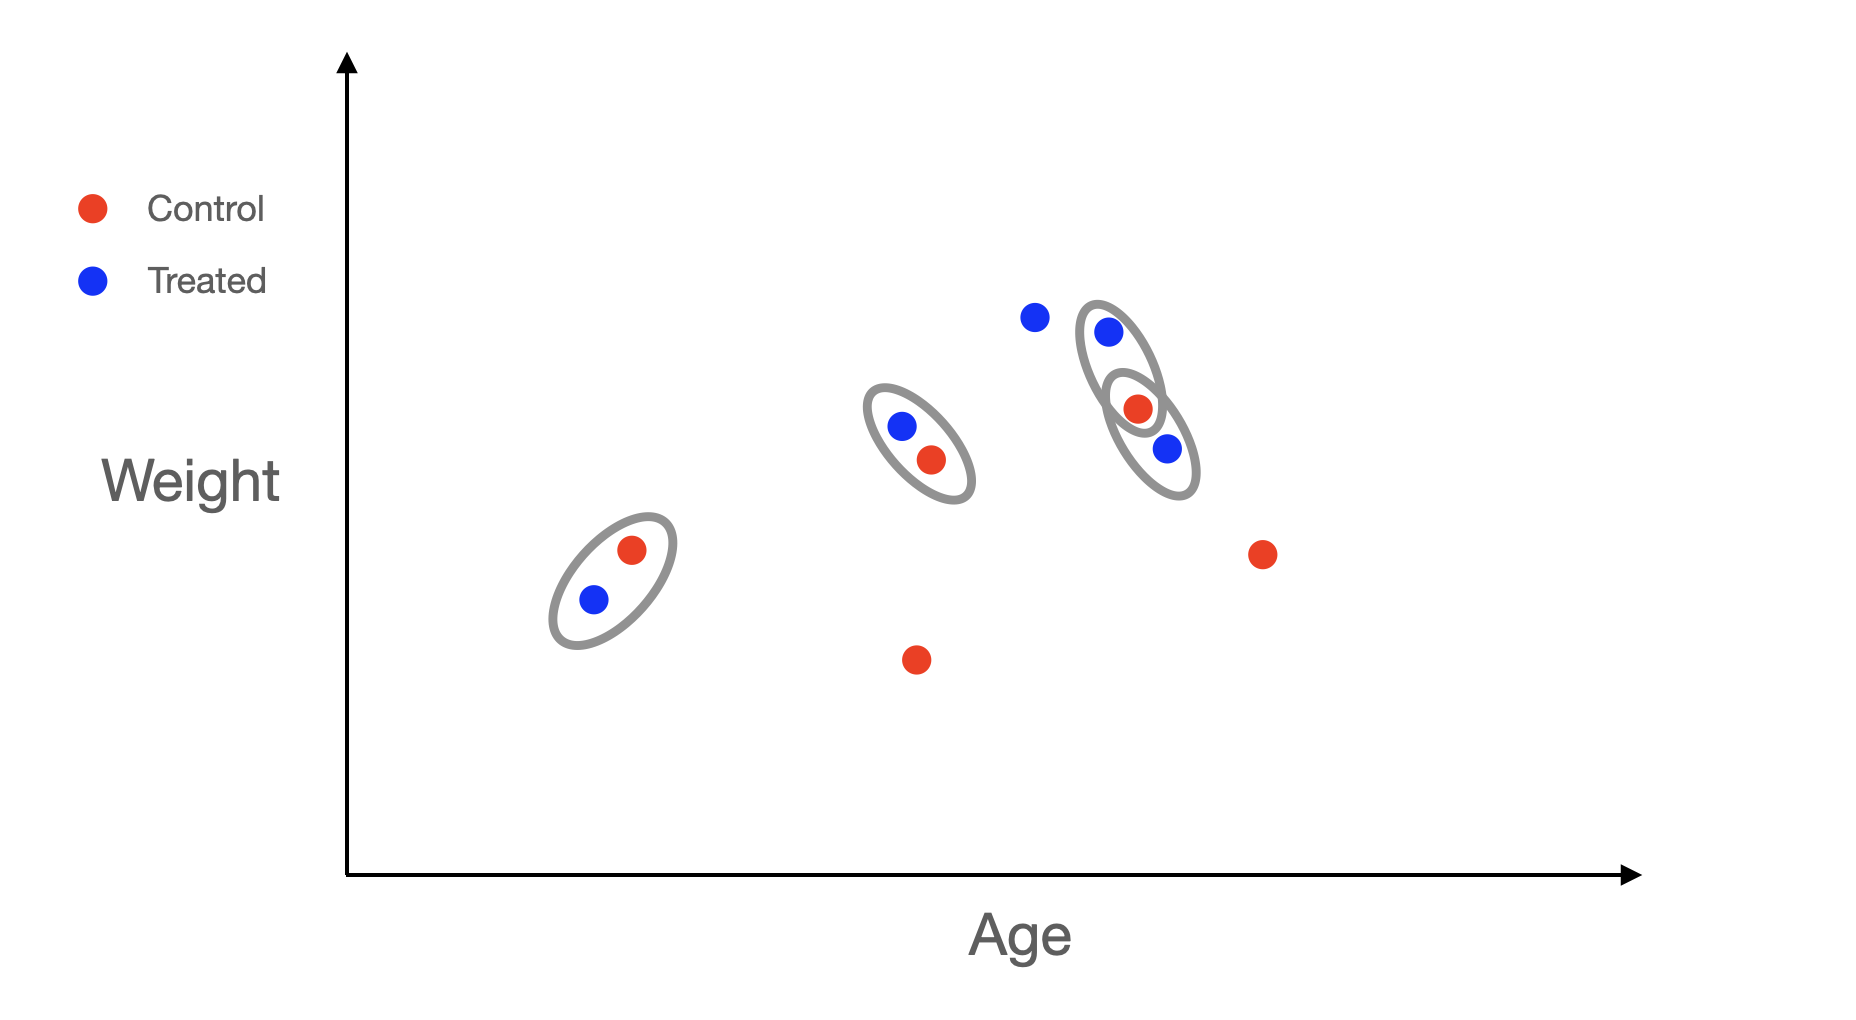


## More on matching
Things to consider:
- How to measure distance between points?
- When will this work well? (Hint: what happens when we have a lot of covariates?)

In [27]:
# no matching
library(MatchIt)

m.out0 <- matchit(treat ~ age + educ + race + married + nodegree + re74 + re75, 
                  data = lalonde, method = NULL, distance = "glm")
summary(m.out0)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = NULL, distance = "glm")

Summary of Balance for All Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5774        0.1822          1.7941     0.9211    0.3774
age              25.8162       28.0303         -0.3094     0.4400    0.0813
educ             10.3459       10.2354          0.0550     0.4959    0.0347
raceblack         0.8432        0.2028          1.7615          .    0.6404
racehispan        0.0595        0.1422         -0.3498          .    0.0827
racewhite         0.0973        0.6550         -1.8819          .    0.5577
married           0.1892        0.5128         -0.8263          .    0.3236
nodegree          0.7081        0.5967          0.2450          .    0.1114
re74           2095.5737     5619.2365         -0.7211     0.5181    0.2248
re75           1532.0553     2466.4844         -0.2903     0.9563

Warning message:
“Standardized mean differences and raw mean differences are present in
the same plot. Use the `stars` argument to distinguish between them and
appropriately label the x-axis. See `?love.plot` for details.”


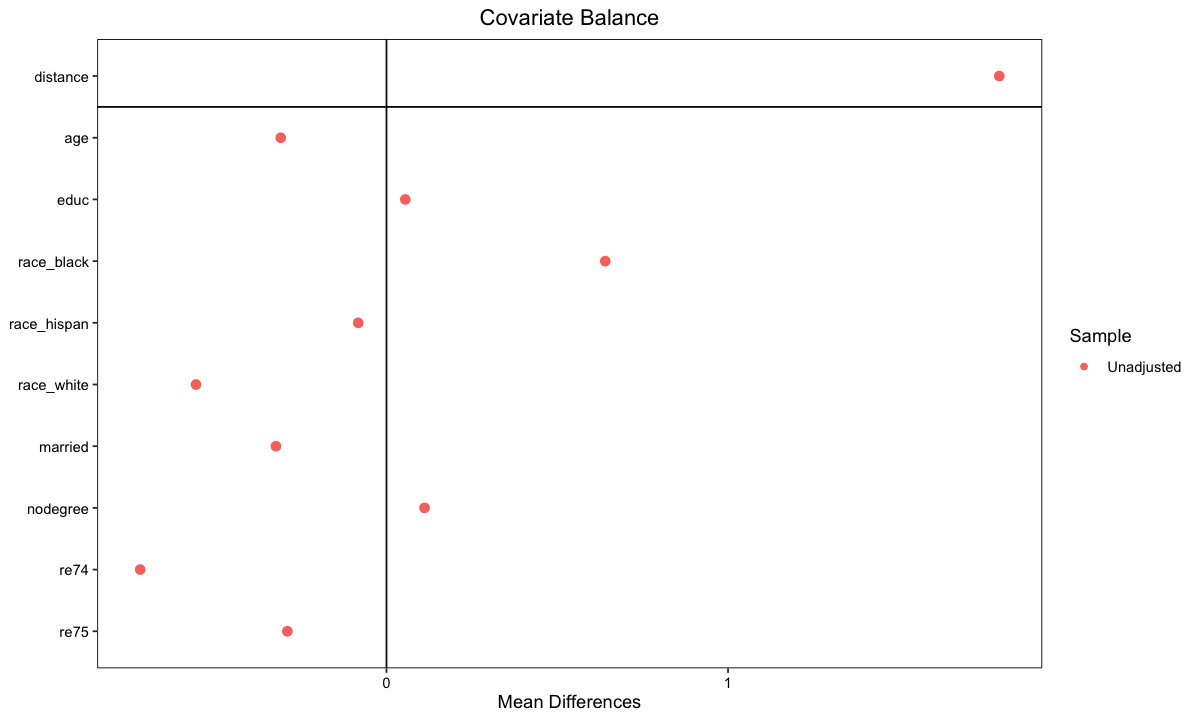

In [28]:
love.plot(m.out0)

- Good balance: $\text{SMD}\approx 0$, $\text{var. ratio} \approx 1$.
- So pretty unbalanced.

In [29]:
m.out1 <- matchit(treat ~ age + educ + race + married + nodegree + re74 + re75, data = lalonde,
                  method = "nearest", distance = "glm")
summary(m.out1, un = F)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = "nearest", distance = "glm")

Summary of Balance for Matched Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5774        0.3629          0.9739     0.7566    0.1321
age              25.8162       25.3027          0.0718     0.4568    0.0847
educ             10.3459       10.6054         -0.1290     0.5721    0.0239
raceblack         0.8432        0.4703          1.0259          .    0.3730
racehispan        0.0595        0.2162         -0.6629          .    0.1568
racewhite         0.0973        0.3135         -0.7296          .    0.2162
married           0.1892        0.2108         -0.0552          .    0.0216
nodegree          0.7081        0.6378          0.1546          .    0.0703
re74           2095.5737     2342.1076         -0.0505     1.3289    0.0469
re75           1532.0553     1614.7451         -0.0257  

Warning message:
“Standardized mean differences and raw mean differences are present in
the same plot. Use the `stars` argument to distinguish between them and
appropriately label the x-axis. See `?love.plot` for details.”


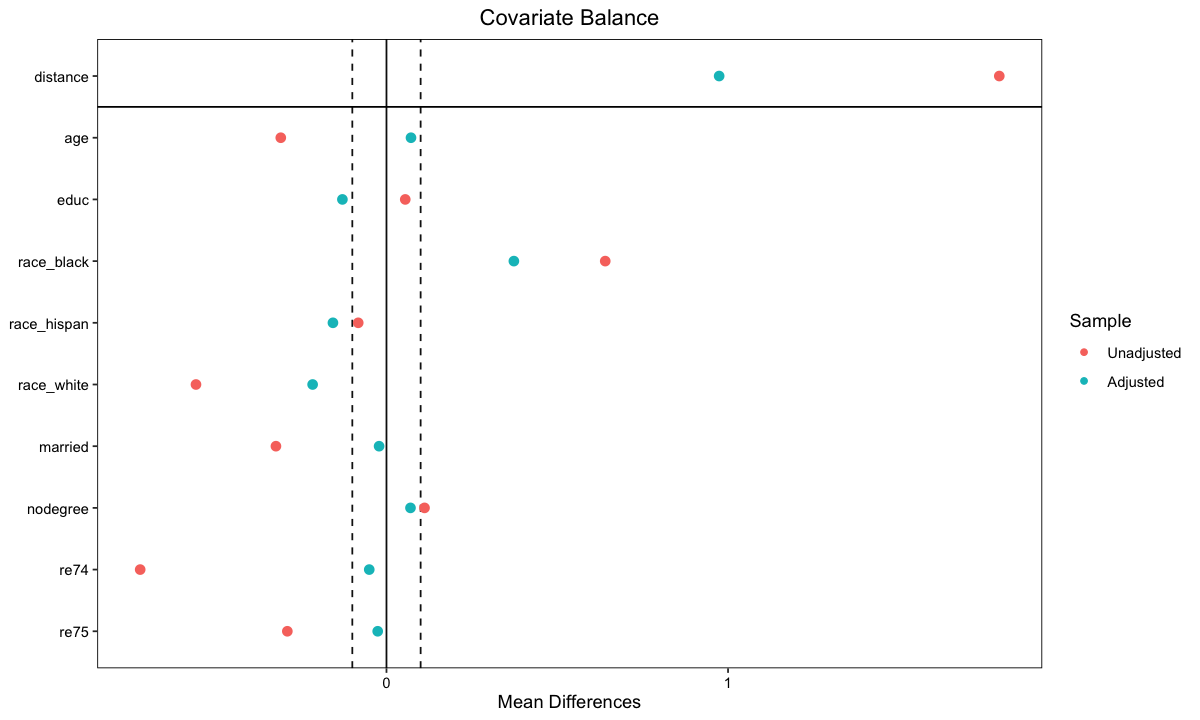

In [30]:
love.plot(m.out1, thresholds = c(m = .1))

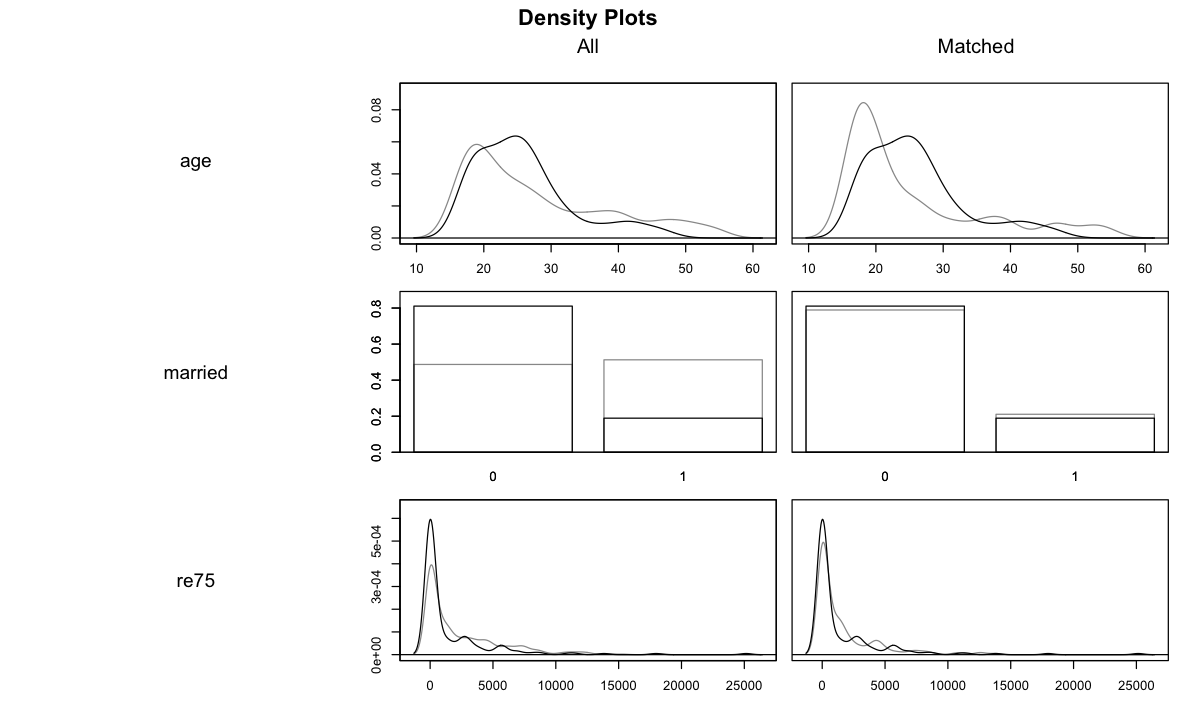

In [31]:
plot(m.out1, type = "density", interactive = FALSE,
     which.xs = ~age + married + re75)  # black=treated, grey=control

In [34]:
# Full matching on a probit PS
library(optmatch)
m.out2 <- matchit(treat ~ age + educ + race + married + 
                  nodegree + re74 + re75, data = lalonde,
                  method = "full", distance = "glm", link = "probit")
summary(m.out2, un = F)


Call:
matchit(formula = treat ~ age + educ + race + married + nodegree + 
    re74 + re75, data = lalonde, method = "full", distance = "glm", 
    link = "probit")

Summary of Balance for Matched Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5773        0.5764          0.0045     0.9949    0.0043
age              25.8162       25.5347          0.0393     0.4790    0.0787
educ             10.3459       10.5381         -0.0956     0.6192    0.0253
raceblack         0.8432        0.8389          0.0119          .    0.0043
racehispan        0.0595        0.0492          0.0435          .    0.0103
racewhite         0.0973        0.1119         -0.0493          .    0.0146
married           0.1892        0.1633          0.0660          .    0.0259
nodegree          0.7081        0.6577          0.1110          .    0.0504
re74           2095.5737     2100.2150         -0.0009     1.3467    0.0314
re75           1532.0553     1561.442

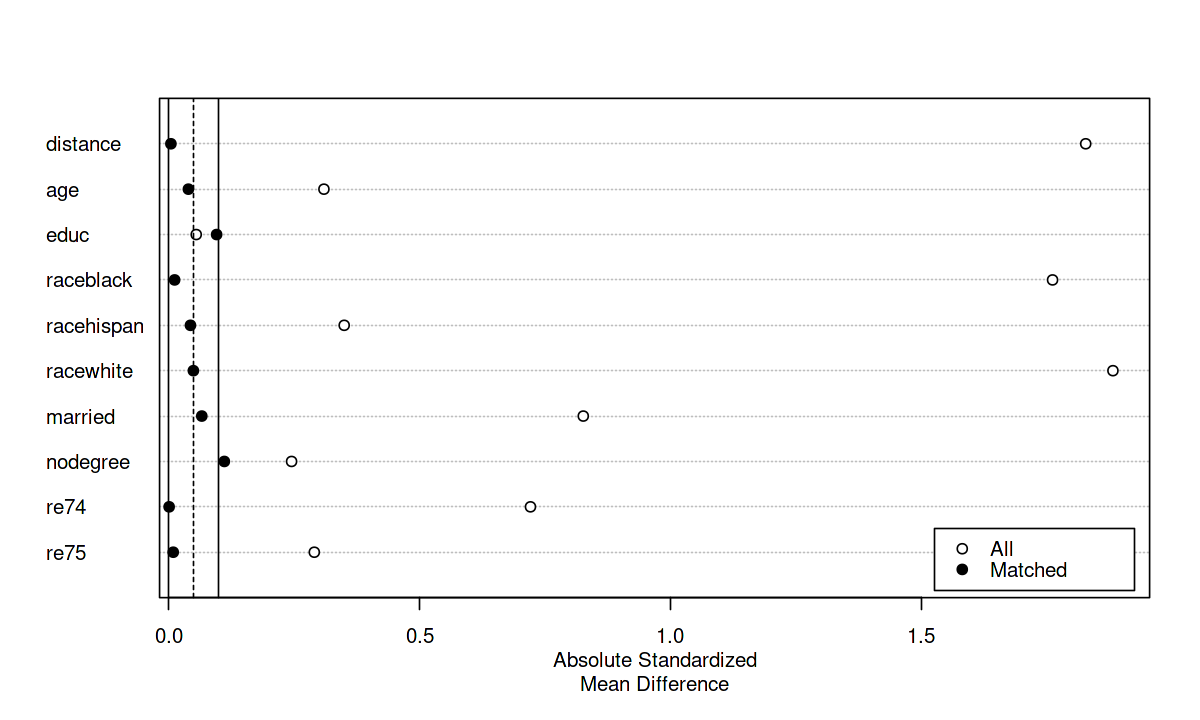

In [42]:
plot(summary(m.out2))

In [35]:
m.data <- match.data(m.out2)
m.data %>% head

,treat,age,educ,race,married,nodegree,re74,re75,re78,distance,weights,subclass
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
NSW1,1,37,11,black,1,1,0,0,9930.0460,0.6356769,1,1
NSW2,1,22,9,hispan,0,1,0,0,3595.8940,0.2298151,1,55
NSW3,1,30,12,black,0,0,0,0,24909.4500,0.6813558,1,63
NSW4,1,27,11,black,0,1,0,0,7506.1460,0.7690590,1,70
NSW5,1,33,8,black,0,1,0,0,289.7899,0.6954138,1,79
NSW6,1,22,9,black,0,1,0,0,4056.4940,0.6943658,1,86


In [36]:
fit <- lm(re78 ~ treat + age + educ + race + married + nodegree + 
             re74 + re75, data = m.data, weights = weights)
summary(fit)


Call:
lm(formula = re78 ~ treat + age + educ + race + married + nodegree + 
    re74 + re75, data = m.data, weights = weights)

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-19550  -2746   -585   1925  54806 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.720e+03  2.061e+03   1.320 0.187361    
treat        1.986e+03  5.362e+02   3.703 0.000232 ***
age         -3.430e+01  2.895e+01  -1.185 0.236604    
educ         2.280e+02  1.400e+02   1.628 0.104020    
racehispan   9.681e+02  1.114e+03   0.869 0.385238    
racewhite    1.468e+03  8.036e+02   1.826 0.068312 .  
married      9.269e+02  7.219e+02   1.284 0.199595    
nodegree    -1.458e+03  7.112e+02  -2.050 0.040752 *  
re74        -7.633e-03  6.999e-02  -0.109 0.913186    
re75         5.501e-01  1.086e-01   5.066 5.41e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6083 on 604 degrees of freedom
Multiple R-squared:  0.1286,	Adjust